In [28]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from enum import IntEnum
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [29]:
# READING DATA

attributes_bmi = {
    "WEIGHTLBTC_A": "weight", #pounds
    "HEIGHTTC_A": "height", #inches
    "BMICAT_A": "bmi_group",
    "PREGNOW_A": "pregnant",
}

attributes = {
    "WEIGHTLBTC_A": "weight", #pounds
    "HEIGHTTC_A": "height", #inches
    "PREGNOW_A": "pregnant",
    "AGEP_A": "age",
    "SEX_A": "gender",
    "EDUCP_A": "education",
    "MARITAL_A": "single",
    "HOUTENURE_A": "owns_home",
    "PARSTAT_A": "parent",
    "DEPFREQ_A": "depression",
    "ANXFREQ_A": "anxiety",
    "POVRATTC_A": "poverty",
    "PHSTAT_A": "health_sat",
    "LSATIS4_A": "life_sat",
    "DRK12MN_A": "alcohol",
    "SLPHOURS_A": "sleep",
    "NOTCOV_A": "insurance",
}

dfs = []
for i in [2]:
    df = pd.read_csv(f"../data/adult2{i}.csv", sep=",")
    dfs.append(df)
    print(f"YEAR {2020+i}\nfeatures: {len(df.columns)}\nentries: {len(df)}")
    for attr in attributes.keys():
        try:
            (f"{attr}: {df[attr].unique()}")
        except:
            print(f"missing {attr} for 202{i}")
df = pd.concat(dfs)
df = df.loc[:, list(attributes.keys())]
df.rename(mapper=attributes, inplace=True, axis=1)


YEAR 2022
features: 637
entries: 27651


In [30]:
df

,weight,height,pregnant,age,gender,education,single,owns_home,parent,depression,anxiety,poverty,health_sat,life_sat,alcohol,sleep,insurance
0,148,68,NaN,85,1,4,3,1,3,5,4,1.92,2,2,0.0,8,2
1,235,74,NaN,64,1,8,1,1,3,5,4,10.30,3,2,9.0,8,2
2,218,69,2.0,37,2,8,1,1,3,4,3,9.36,3,1,0.0,9,2
3,240,64,NaN,72,2,5,2,1,3,5,5,3.66,2,1,12.0,8,2
4,183,66,NaN,84,2,6,3,1,3,5,4,0.69,2,2,1.0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27646,180,70,NaN,64,1,4,3,1,3,5,5,3.54,3,2,NaN,7,1
27647,142,66,NaN,67,2,8,1,1,3,4,3,3.35,2,2,NaN,8,2
27648,125,60,NaN,69,2,7,1,1,3,5,5,4.88,1,1,1.0,7,2
27649,250,75,NaN,30,1,7,1,1,1,5,5,2.30,2,1,0.0,6,2


In [31]:
print(len(df))
# removing invalid values
df = df[df["weight"] <= 299]
df = df[df["height"] <= 76]
df = df[df["gender"] <= 2]
df = df[((df["pregnant"] == 2) | (df["gender"] == 1))]
df = df[df["age"] <= 84]
df = df[df["education"] <= 10]
df = df[df["single"] <= 3]
df = df[df["owns_home"] <= 2]
df = df[df["parent"] <= 3]
df = df[df["depression"] <= 5]
df = df[df["anxiety"] <= 5]
df = df[df["poverty"] < 11]
df = df[df["health_sat"] < 6]
df = df[df["life_sat"] < 5]
df = df[df["alcohol"] < 366]
df = df[df["sleep"] < 25]
df = df[df["insurance"] <= 2]

for attr in attributes.values():
    print(f"{attr}: {df[attr].unique()}")
print(len(df))


27651


weight: [235 218 195 200 160 158 173 120 250 180 135 220 198 230 242 175 185 144
 240 155 130 168 210 255 184 161 142 190 125 150 145 139 245 165 202 115
 143 147 153 177 172 117 134 140 170 193 132 215 260 233 107 207 194 199
 110 188 217 167 271 100 179 205 294 225 183 171 206 189 265 152 257 253
 156 275 248 224 209 138 181 204 244 263 187 182 290 174 178 280 192 201
 166 122 162 176 252 227 118 148 128 243 169 104 270 285 186 211 208 212
 136 197 105 232 151 237 292 284 228 146 157 295 293 241 163 251 287 149
 121 223 129 219 123 102 259 222 221 112 159 256 216 191 127 164 238 226
 196 214 137 274 268 116 119 272 154 106 236 141 203 286 213 124 258 239
 234 262 108 296 261 133 113 289 111 229 249 266 126 298 103 267 254 288
 246 131 114 276 273 278 247 109 269 277 231 291 264 283 101 299 297 281
 279]
height: [74 69 68 71 67 65 72 64 70 63 66 62 76 61 75 73 60 59]
pregnant: [nan  2.]
age: [64 37 81 68 27 58 46 42 59 74 32 25 45 47 62 61 24 55 69 43 72 60 23 65
 80 35 34 20 26 38 36

In [32]:
# regrouping


"""
EDUCATION
00 (no edu), 01 (no hs), 02 (no diploma): no_hs
03 (ged), 04 (hs), 05 (no deg): highschool
06 (occupational deg), 07 (academic deg), 08 (bsc): bachelor
09 (msc): masters
10 (phd): phd
"""

"""
MARITAL status:
03: single
01 (married) 2 (cohabiting): not
"""

"""
parent
01: parent
02 (in famility but not) 03 (not in family): not
"""

class EduLevel(IntEnum):
    NO_HIGHSCHOOL = 0
    HIGHSCHOOL = 1
    BACHELORS = 2
    MASTERS = 3
    PHD = 4
    

df["education"] = df["education"].replace({
    1: EduLevel.NO_HIGHSCHOOL,
    2: EduLevel.NO_HIGHSCHOOL,
    3: EduLevel.HIGHSCHOOL,
    4: EduLevel.HIGHSCHOOL,
    5: EduLevel.HIGHSCHOOL,
    6: EduLevel.BACHELORS,
    7: EduLevel.BACHELORS,
    8: EduLevel.BACHELORS,
    9: EduLevel.MASTERS,
    10: EduLevel.PHD
})

df["single"] = df["single"].replace({
    1: False,
    2: False,
    3: True
})

df["parent"] = df["parent"].replace({
    1: True,
    2: False,
    3: False
})

/tmp/ipykernel_368075/2400040990.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["single"] = df["single"].replace({
/tmp/ipykernel_368075/2400040990.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["parent"] = df["parent"].replace({


In [33]:
# BMI calculation
POUND_TO_KG = 0.453592
INCH_TO_M = 0.0254
df["weight"] = df["weight"] * POUND_TO_KG
df["height"] = df["height"] * INCH_TO_M
df["bmi"] = df["weight"] / df["height"] ** 2

""" del df["weight"]
del df["height"]
del df["pregnant"] """


' del df["weight"]\ndel df["height"]\ndel df["pregnant"] '

In [34]:

df["life_sat"] = df["life_sat"] - 1
df["gender"] = df["gender"] - 1
df["owns_home"] = df["owns_home"] - 1

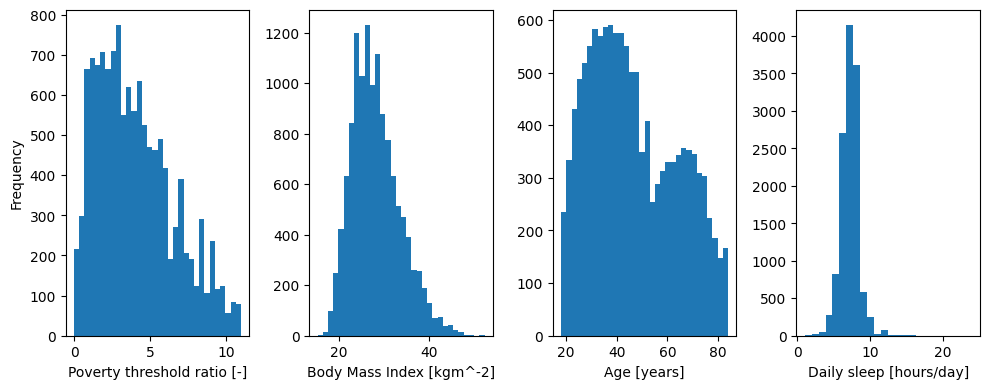

In [35]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].hist(df["poverty"], bins=32)
axs[1].hist(df["bmi"], bins=32)
axs[2].hist(df["age"], bins=32)
axs[3].hist(df["sleep"], bins=24)

axs[0].set(xlabel="Poverty threshold ratio [-]", ylabel="Frequency")
axs[1].set(xlabel="Body Mass Index [kgm^-2]")
axs[2].set(xlabel="Age [years]")
axs[3].set(xlabel="Daily sleep [hours/day]")

fig.tight_layout()

In [36]:
df.head()

,weight,height,pregnant,age,gender,education,single,owns_home,parent,depression,anxiety,poverty,health_sat,life_sat,alcohol,sleep,insurance,bmi
1,106.594120,1.8796,NaN,64,0,2,False,0,False,5,4,10.30,3,1,9.0,8,2,30.171880
2,98.883056,1.7526,2.0,37,1,2,False,0,False,4,3,9.36,3,0,0.0,9,2,32.192616
10,88.450440,1.7272,NaN,81,0,1,True,0,False,4,4,1.53,3,1,0.0,8,2,29.649320
11,90.718400,1.8034,NaN,68,0,1,True,0,False,5,5,3.61,1,0,2.0,10,2,27.894029
18,72.574720,1.7018,NaN,27,0,4,True,1,False,4,4,4.25,1,0,4.0,6,2,25.059265


In [37]:
def bin_plot(by, target, binwidth):
    """takes a feature `by` to group by into `binwidth` bins and plot the median and sted values of `target` for each bin """
    df2 = df[[by, target]].copy()
    df2[f"{by}_bin"] = (df2[by] // binwidth).astype(int)
    dfg = df2.groupby(by=f"{by}_bin").agg({target: ["mean", "count", "std", "min", "max", "median"]})
    x =dfg.index.values
    y = dfg[target, "mean"]
    fig, ax = plt.subplots(1)
    ax.errorbar(x, y, yerr=dfg[target, "std"], fmt='ro', ecolor="blue", capsize=5)
    ax.set(xlabel=f"{by} bin", ylabel=f"{target} average")

"""
good ones:
- age vs anxiety

"""

'\ngood ones:\n- age vs anxiety\n\n'

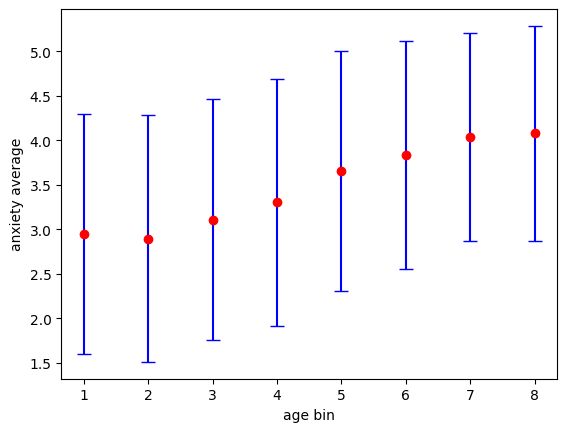

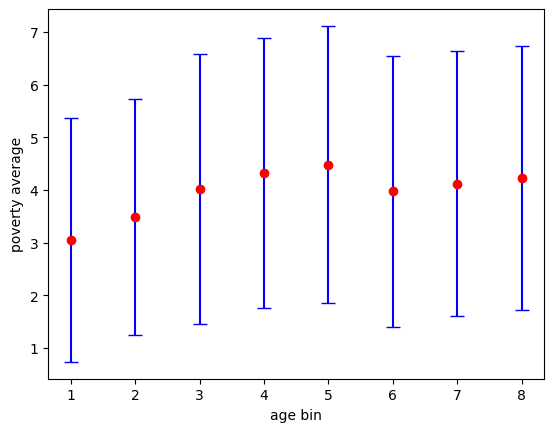

In [38]:
bin_plot(by="age", target="anxiety", binwidth=10)
bin_plot(by="age", target="poverty", binwidth=10)

In [39]:
df.head()

,weight,height,pregnant,age,gender,education,single,owns_home,parent,depression,anxiety,poverty,health_sat,life_sat,alcohol,sleep,insurance,bmi
1,106.594120,1.8796,NaN,64,0,2,False,0,False,5,4,10.30,3,1,9.0,8,2,30.171880
2,98.883056,1.7526,2.0,37,1,2,False,0,False,4,3,9.36,3,0,0.0,9,2,32.192616
10,88.450440,1.7272,NaN,81,0,1,True,0,False,4,4,1.53,3,1,0.0,8,2,29.649320
11,90.718400,1.8034,NaN,68,0,1,True,0,False,5,5,3.61,1,0,2.0,10,2,27.894029
18,72.574720,1.7018,NaN,27,0,4,True,1,False,4,4,4.25,1,0,4.0,6,2,25.059265


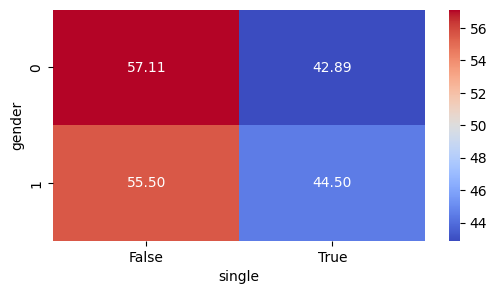

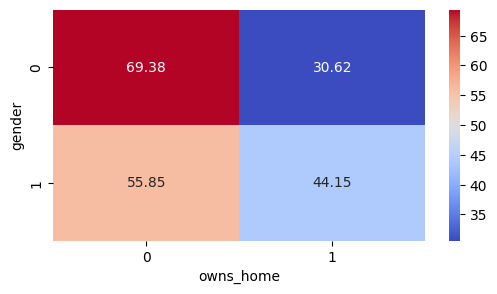

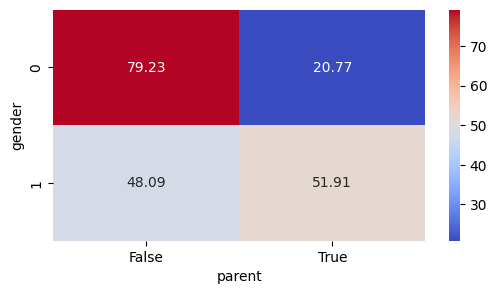

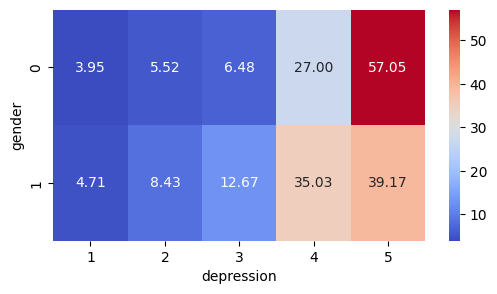

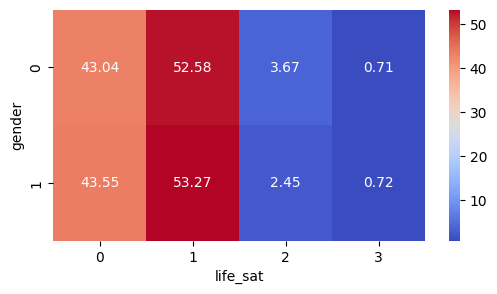

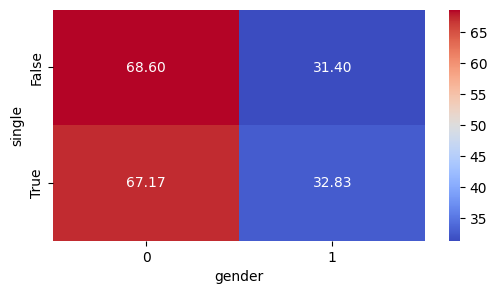

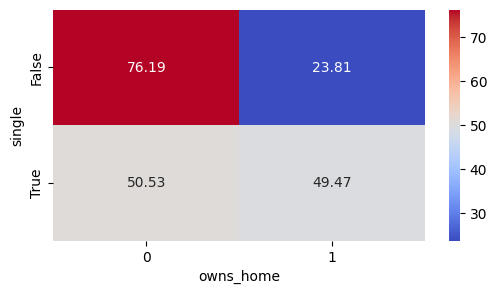

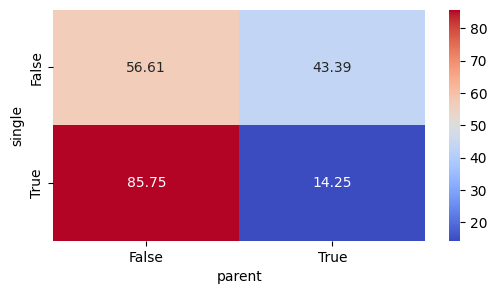

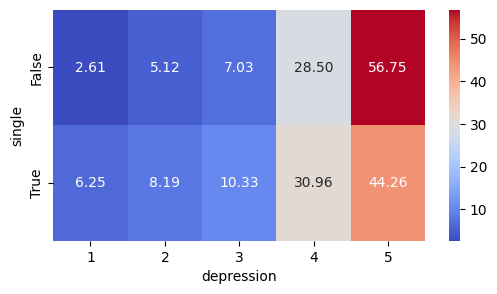

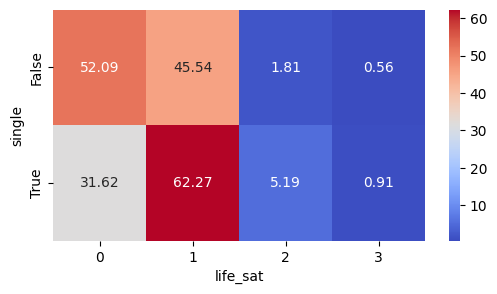

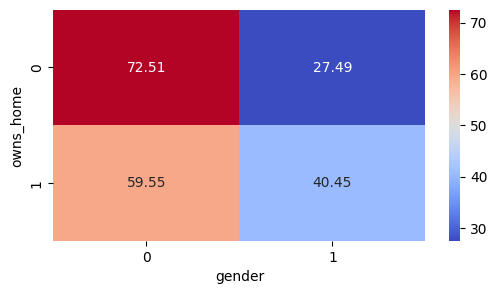

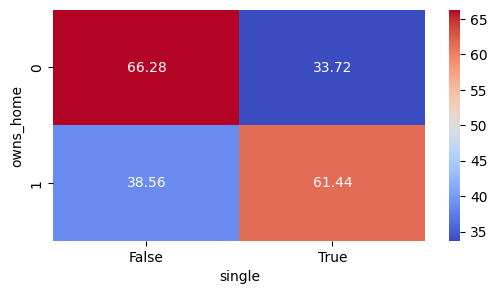

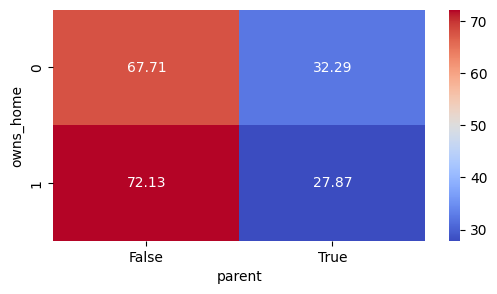

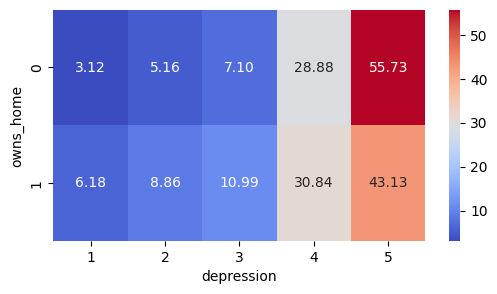

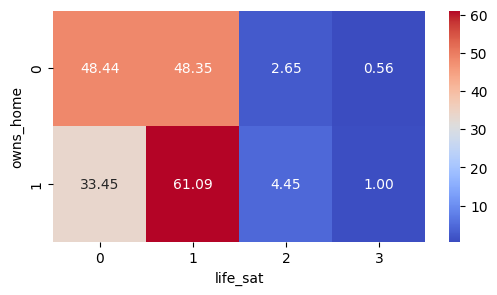

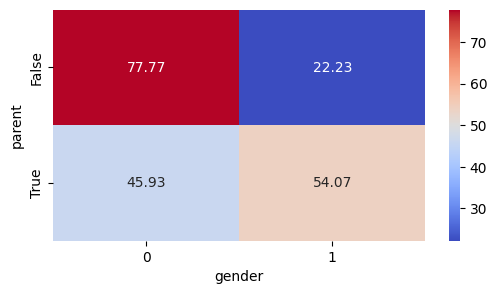

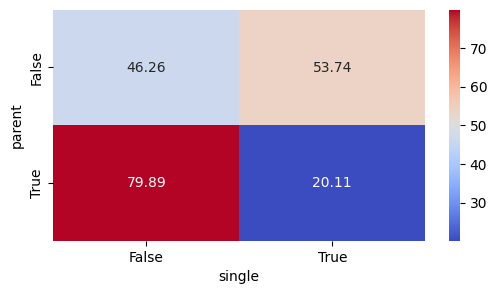

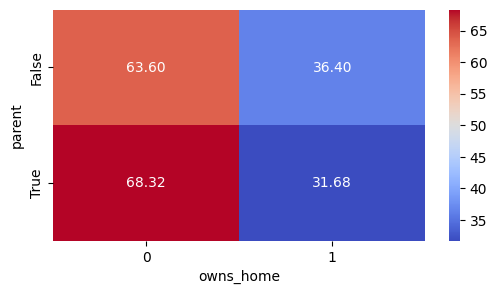

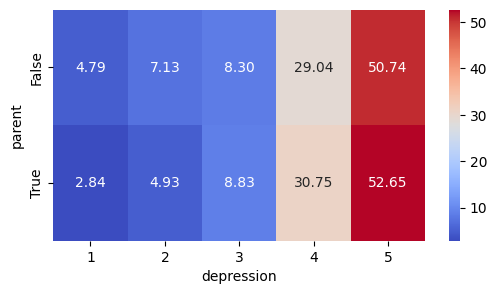

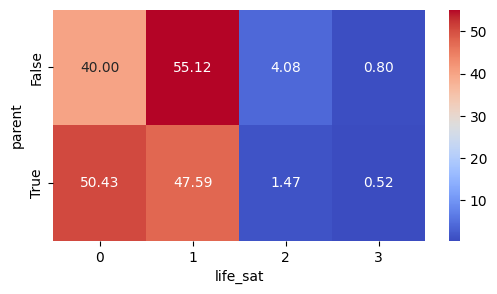

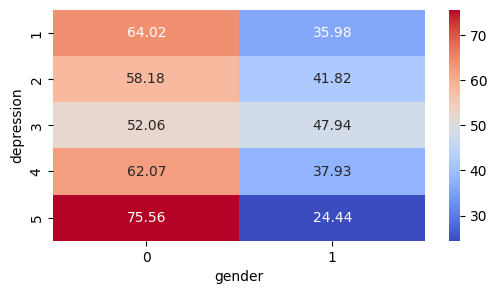

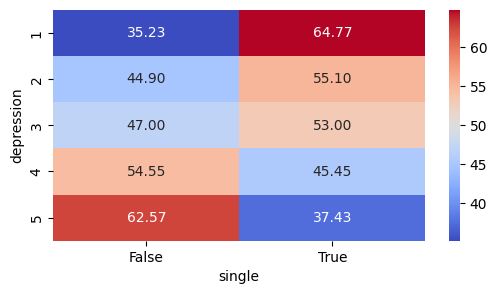

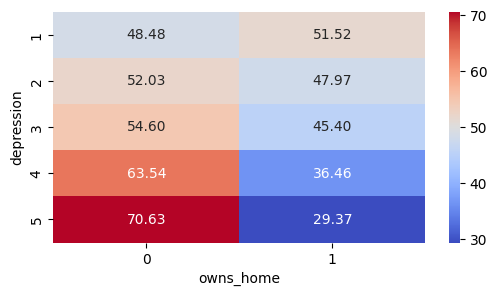

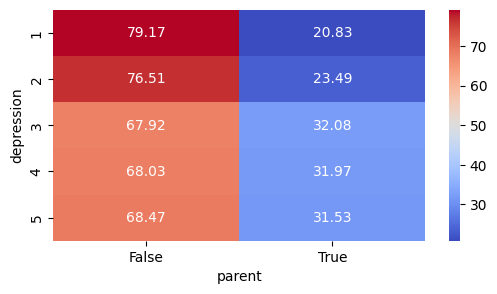

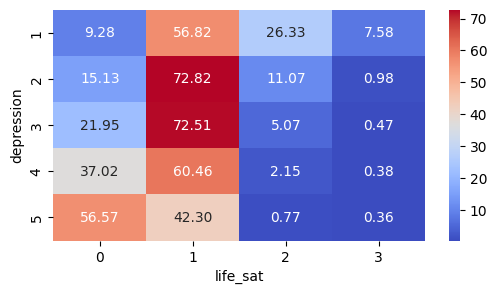

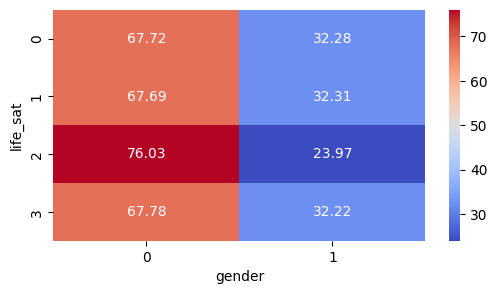

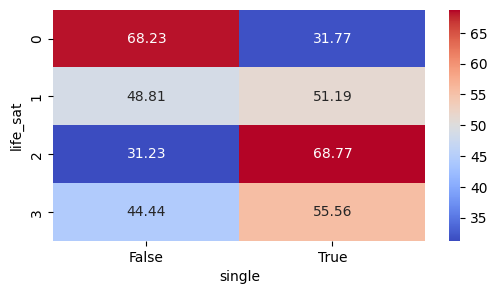

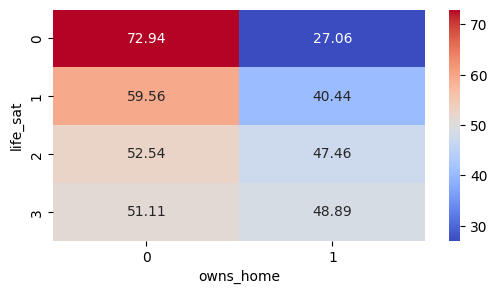

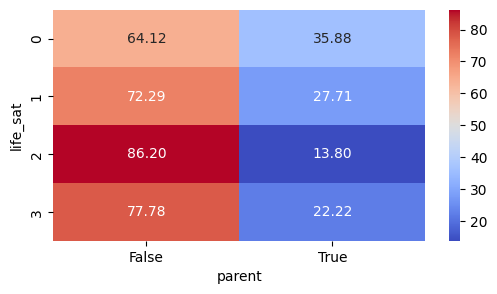

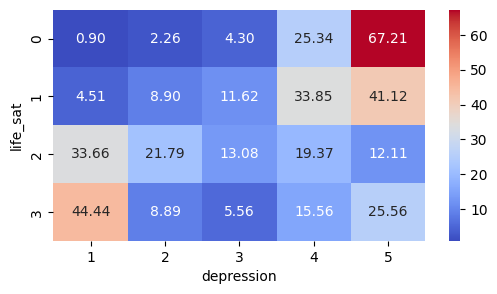

In [48]:
categorical_features = ["gender", "single", "owns_home", "parent", "depression", "life_sat"]
for f1 in categorical_features:
    for f2 in categorical_features:
        if f1 != f2:
            tab = pd.crosstab(df[f1], df[f2], normalize="index") * 100
            try:
                plt.figure(figsize=(6, 3))
                sns.heatmap(tab, fmt='.2f', cmap='coolwarm', annot=True)
                plt.show()
            except Exception as e:
                print(e)

/tmp/ipykernel_368075/2393996616.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["age"]+features)
/tmp/ipykernel_368075/2393996616.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["age"]+features)


[Text(0.5, 0, 'sleep [hours/day]]'), Text(0, 0.5, 'BMI index [kgm^-2]')]

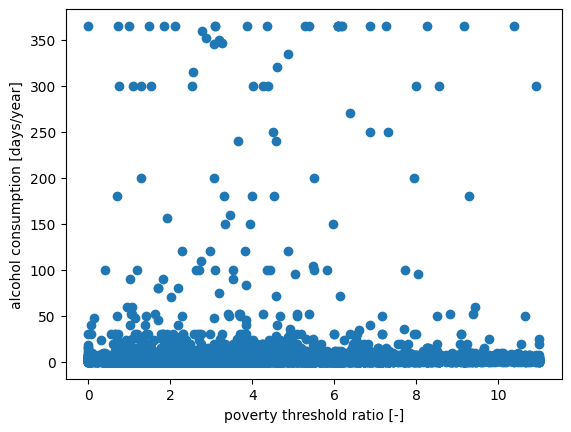

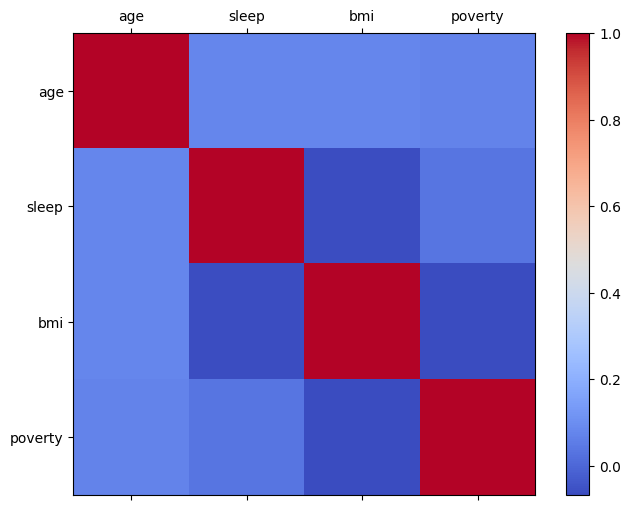

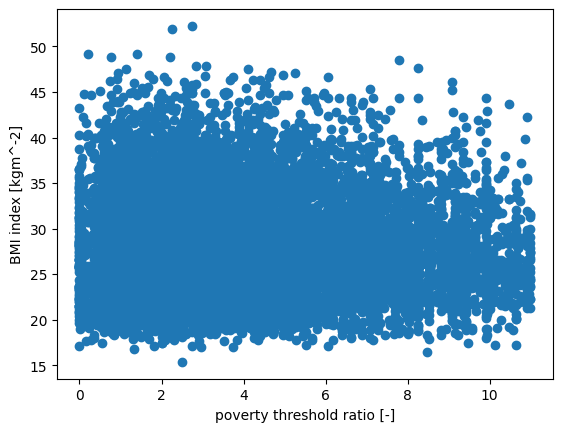

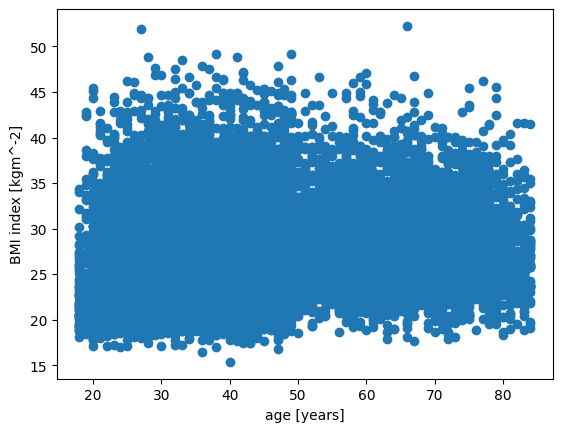

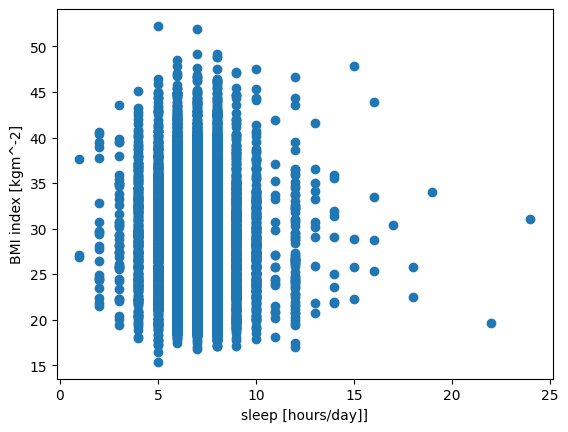

In [41]:
fig, ax = plt.subplots(1)
ax.scatter(df["poverty"], df["alcohol"])
ax.set(xlabel="poverty threshold ratio [-]", ylabel="alcohol consumption [days/year]")


features = ["age", "sleep", "bmi", "poverty"]
fig, ax = plt.subplots(1, figsize=(8, 6))
corr_matrix = df[features].corr(method="pearson")
cax = ax.matshow(corr_matrix, cmap='coolwarm')  
fig.colorbar(cax)
ax.set_xticklabels(["age"]+features)
ax.set_yticklabels(["age"]+features)
""" a = ["parent","life_sat"]
table = pd.crosstab(columns=[df[x] for x in a], index=df.index).sum()
table """

fig, ax = plt.subplots(1)
ax.scatter(df["poverty"], df["bmi"])
ax.set(xlabel="poverty threshold ratio [-]", ylabel="BMI index [kgm^-2]")

fig, ax = plt.subplots(1)
ax.scatter(df["age"], df["bmi"])
ax.set(xlabel="age [years]", ylabel="BMI index [kgm^-2]")

fig, ax = plt.subplots(1)
ax.scatter(df["sleep"], df["bmi"])
ax.set(xlabel="sleep [hours/day]]", ylabel="BMI index [kgm^-2]")

In [42]:
df["age"] = (df["age"] - df["age"].min()) / (df["age"].max() - df["age"].min())
df["poverty"] = (df["poverty"] - df["poverty"].min()) / (df["poverty"].max() - df["poverty"].min())
df["bmi"] = (df["bmi"] - df["bmi"].min()) / (df["bmi"].max() - df["bmi"].min())
df = pd.get_dummies(df, columns=["education", "anxiety", "health_sat"])

In [43]:
X = df.drop(["life_sat"], axis=1)
y = df["life_sat"]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# reweighting
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))
sample_weights = np.array([class_weight_dict[label] for label in y_train])

""" model = XGBClassifier(
    n_estimators=1000,       # Number of boosting rounds
    learning_rate=0.2,      # Step size shrinkage
    max_depth=6,            # Maximum depth of trees
    random_state=42,        # Random seed
) """

model = KNeighborsClassifier(n_neighbors=11, weights="distance")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy score:", accuracy_score(y_true=y_test, y_pred=y_pred))
print(classification_report(y_test, y_pred))


ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values